In [1]:
# Importing libraries we will need for our NLP
import nltk
nltk.download('punkt')
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()

import numpy as np
import random

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.layers import Dense, Activation
from keras import utils
from keras import layers

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# import our chat-bot intents file
import json
with open('intents.json') as json_data:
    intents = json.load(json_data)

In [3]:
words = []
classes = []
documents = []
ignore_words = ['?']
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = nltk.word_tokenize(pattern)
        # add to our words list
        words.extend(w)
        # add to documents in our corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

# stem and lower each word and remove duplicates
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# remove duplicates
classes = sorted(list(set(classes)))

print (len(documents), "documents")
print (len(classes), "classes", classes)
print (len(words), "unique stemmed words", words)

40 documents
10 classes ['cognitive-behavioural-therapy', 'doctor', 'goodbye', 'greeting', 'heart-disease', 'heartrates', 'heartrates-reading', 'noanswer', 'options', 'thanks']
85 unique stemmed words ["'s", ',', '.', 'abl', 'acc', 'alway', 'am', 'and', 'anxy', 'anyon', 'ar', 'be', 'beat', 'becaus', 'book', 'bye', 'calc', 'can', 'check', 'chronic', 'common', 'condit', 'could', 'day', 'depress', 'die', 'diseas', 'do', 'doct', 'feel', 'for', 'get', 'good', 'goodby', 'hav', 'heart', 'hello', 'help', 'hi', 'how', 'hum', 'i', 'is', 'just', 'kil', 'know', 'lat', 'lik', 'me', 'meas', 'might', 'most', 'my', 'nee', 'no', 'of', 'off', 'on', 'proc', 'provid', 'rat', 'recommend', 'see', 'sick', 'simpl', 'situ', 'soon', 'step', 'support', 'surv', 'symptom', 'tak', 'tel', 'thank', 'that', 'the', 'ther', 'thi', 'tir', 'to', 'want', 'what', 'wil', 'yo', 'you']


In [4]:
# create our training data
training = []
output = []
# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # stem each word
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # create our bag of words array
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag
    output_row = list(output_empty)
    #print(classes.index(doc[1]))
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

In [5]:
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)

# create train and test lists
train_x = list(training[:,0])
train_y = list(training[:,1])

In [6]:
model = Sequential()
model.add(Dense(132, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

model.summary()
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
history = model.fit(np.array(train_x), np.array(train_y), epochs=500, batch_size=5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 132)               11352     
_________________________________________________________________
dropout (Dropout)            (None, 132)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8512      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 20,514
Trainable params: 20,514
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
8/8 [==============================] - 0s 3ms/step - loss: 2.4812 - acc: 0.1250
Epoch 2/500
8/8 [=========

In [7]:
model.save('model_ChatBot.h5')

In [8]:
cvscores = []
scores = model.evaluate(train_x,train_y)
print("%s: %.3f%%" % (model.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)
print("%.3f%% (+/- %.3f%%)" % (np.mean(cvscores), np.std(cvscores)))

2/2 [==============================] - 0s 3ms/step - loss: 0.0350 - acc: 0.9750
acc: 97.500%
97.500% (+/- 0.000%)


In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc'])

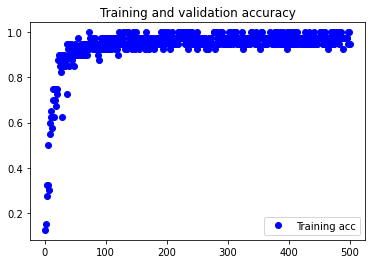

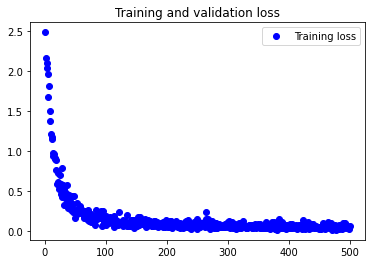

In [10]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
def clean_up_sentence(sentence):
    # tokenize the pattern
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word
    sentence_words = [stemmer.stem(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=False):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)

    return(np.array(bag))

In [12]:
p = bow("How to get the most accurate heart rates", words)
print (p)
print (classes)

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0]
['cognitive-behavioural-therapy', 'doctor', 'goodbye', 'greeting', 'heart-disease', 'heartrates', 'heartrates-reading', 'noanswer', 'options', 'thanks']


In [13]:
d = len(p)
f = len(documents)-2
a = np.zeros([f, d])

In [14]:
tot = np.vstack((p,a))

In [15]:
tot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
prediction = model.predict(tot)
predicted_index = np.argmax(prediction)
predicted_index

6